This notebook implements the model where Attention network is Fully Connected Feed Forward Network.</br>
Run all code cells sequentially

In [ ]:
!unzip NSE_Dataset.zip -d NSE_Dataset

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler


In [5]:
project_dir = ''
data_dir = 'NSE_Dataset'

In [6]:
#Primary input series (we aim to predict stock price of AXIS BANK)
df1 = pd.read_csv(data_dir + '/AXISBANK.csv')

#Secondary input series (we use these series to train the attention model)
df2 = pd.read_csv(data_dir + '/HDFCBANK.csv')  
df4 = pd.read_csv(data_dir + '/ICICIBANK.csv') 
df6 = pd.read_csv(data_dir + '/KOTAKBANK.csv') 
df8 = pd.read_csv(data_dir + '/INFY.csv')
df11 = pd.read_csv(data_dir + '/RELIANCE.csv')


Data Preprocessing

In [7]:
# Eliminate price changes due to Stock Splits and Bonus Issue

dates_axis = ['2014-07-28']
dates_hdfc = ['2011-07-14', '2019-09-19']
dates_icici = ['2014-12-04', '2017-06-20']
dates_kotak = ['2004-08-25', '2005-08-25', '2010-09-13', '2015-07-08']
dates_infy = ['2004-07-01', '2006-07-13', '2014-12-02', '2015-06-15', '2018-09-04']
dates_tsteel = ['2004-08-11']
dates_reliance = ['2009-11-26', '2017-09-07']
for df, price_split_dates in zip([df1, df2, df4, df6, df8, df11], \
                                 [dates_axis, dates_hdfc, dates_icici, dates_kotak, dates_infy, dates_reliance]):
  for dt in price_split_dates:
    diff = df.loc[df['Date'] == dt]['Prev Close'] - df.loc[df['Date'] == dt]['Open']
    for col in ['Prev Close', 'Open', 'Low', 'High', 'Close']:
      df.loc[df['Date'] >= dt, col] += float(diff)

#df2.loc[df1['Date'].isin(['2019-09-19'])]

In [8]:
def moving_avg(a, n):
  b = np.copy(a)
  for i in range(n, len(a)+1):
    b[i-1] = np.mean(a[i-n:i])
  return b

In [9]:
# MinMax Scaling with range [0-5]
moving_avg_n = 10
scalers = []
scaled_X = []
tot_seq_len = len(df1)
for i, df in enumerate([df1, df2, df4, df6, df8, df11]):
  scaler = MinMaxScaler(feature_range=(0, 5))
  scaled_X.append(moving_avg(np.reshape(np.array(df['Close']), (-1, 1)), moving_avg_n))
  scaled_X[i] = scaler.fit_transform(scaled_X[i])
  if len(df) < tot_seq_len:
    scaled_X[i] = np.concatenate((scaled_X[i][0:tot_seq_len-len(df)], scaled_X[i]))
  scalers.append(scaler)  

In [12]:
# Dataset formation

class Dataset(torch.utils.data.Dataset):
  def __init__(self, input_seqs, start, end, inp_len, oup_len):
    self.X = []
    self.y = []
    
    for seq in input_seqs:
      Xt = []
      yt = []
      for i in range(start+inp_len, end-oup_len):
        Xt.append(torch.Tensor(seq[i-inp_len:i]).to(device))
        yt.append(torch.Tensor(seq[i:i+oup_len]).to(device))
      self.X.append(np.array(Xt))
      self.y.append(np.array(yt))
    self.len = len(self.X[0])

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    X = []
    y = []
    for i in range(len(self.X)):
      X.append(self.X[i][index])
      y.append(self.y[i][index])     
    return (X, y)

inp_len = 60
oup_len = 30 #10
n_companies = 6
lstm_hidden = 50

n_train = int(len(scaled_X[0])*0.8)
train_dataset = Dataset(scaled_X, 0, n_train+oup_len, inp_len, oup_len)
test_dataset = Dataset(scaled_X, n_train-inp_len, len(scaled_X[0]), inp_len, oup_len)

Model Implementation

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

In [18]:
class AttentionLayer(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super(AttentionLayer, self).__init__()
    self.scores = []
    self.model = nn.Sequential(
        nn.Linear(in_features=n_inputs, out_features=n_hidden, bias=True),
        nn.ReLU(inplace=False),
        nn.Linear(in_features=n_hidden, out_features=n_outputs, bias=True),
        nn.Softmax(dim=-1)
        )
    
  def forward(self, inputs):
    [seq, val] = inputs
    for i in range(0, len(seq)):
      val[i] = val[i].detach()
    x = torch.cat(seq, dim=1)
    
    self.scores = self.model(torch.squeeze(x, dim=2))
    z=self.scores[:,0]
    z=torch.reshape(z, (-1, 1))
    output = (z*val[0]) 
    for i in range(1, len(seq)):
      z=self.scores[:,i]
      z=torch.reshape(z, (-1, 1))
      output += z*val[i] 

    return output

In [19]:
class LSTMModel(nn.Module):
  def __init__(self, lstm_units, n_companies, out_seq):
    super(LSTMModel, self).__init__()
    self.lstm_units = lstm_units
    self.n_companies = n_companies
    self.out_seq = out_seq #Length of final output sequene of the model

    self.lstm_1 = []
    self.lstm_2 = []
    self.lstm_3 = []
    self.dense = []
    self.weights = []

    for i in range(self.n_companies):
      self.lstm_1.append(nn.LSTM(input_size=1, hidden_size=self.lstm_units, num_layers=1, batch_first=True).to(device))#dropout=0.2, 
      self.lstm_2.append(nn.LSTM(input_size=self.lstm_units, hidden_size=self.lstm_units, num_layers=1, batch_first=True).to(device))#dropout=0.2, 
      self.lstm_3.append(nn.LSTM(input_size=self.lstm_units, hidden_size=self.lstm_units, num_layers=1, batch_first=True).to(device))#dropout=0.2, 
      self.dense.append(nn.Linear(in_features=self.lstm_units, out_features=self.out_seq, bias=True).to(device))
      self.weights.append([self.lstm_1[i].parameters(), self.lstm_2[i].parameters(), \
                           self.lstm_3[i].parameters(), self.dense[i].parameters()])

  def forward(self, inputs):
    lstm1_seq = []
    lstm1_hn = []
    for i in range(self.n_companies):
      out, (h, c) = self.lstm_1[i](inputs[i].float())
      lstm1_seq.append(out)
      lstm1_hn.append(torch.squeeze(h, dim=0))

    lstm2_seq = []
    lstm2_hn = []
    
    for i in range(0, self.n_companies):
      out, (h, c) = self.lstm_2[i](lstm1_seq[i])
      lstm2_seq.append(out)
      lstm2_hn.append(torch.squeeze(h, dim=0))
    
    lstm3_seq = []
    lstm3_hn = []
    
    for i in range(0, self.n_companies):
      out, (h, c) = self.lstm_3[i](lstm2_seq[i])
      lstm3_seq.append(out)
      lstm3_hn.append(h)
    out = []  
    for i in range(0, self.n_companies):
      out.append(self.dense[i](lstm3_hn[i]))
  
    return out


In [16]:
 np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

Model Training

In [24]:
# Training loop
batch_size = 128 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

epochs = 150
epoch_start = 0
lr = 0.0007
pred_model = LSTMModel(lstm_units=lstm_hidden, n_companies=n_companies, out_seq=oup_len)
pred_model.to(device)
optimizers = []
losses_fn = []
for pw in pred_model.weights:
  w = [item for sublist in pw for item in sublist]
  optimizers.append(optim.Adam(w, lr))
  losses_fn.append(nn.MSELoss())

attention1 = AttentionLayer(n_inputs=n_companies*inp_len, n_hidden=inp_len, n_outputs=n_companies)
attention1.to(device)
att_optim = optim.Adam(attention1.parameters(), lr)
att_loss_fn = nn.MSELoss()

lstm_loss2 = []
att_loss2 = []

for epoch in range(epoch_start, epochs):
  lstm_loss = []
  att_loss = []
  for j in range(n_companies):
    lstm_loss.append([])
  for i, data in enumerate(train_loader):
    X, y = data    
    out = pred_model(X)
    for j, pred in enumerate(out):
      optimizers[j].zero_grad()
      pred = torch.unsqueeze(torch.squeeze(pred, dim=0), dim=2)
      l = losses_fn[j](pred, y[j].float())
      l.backward()
      optimizers[j].step()
      lstm_loss[j].append(l)
    
    att_optim.zero_grad()
    att_out = attention1([X, out])    
    att_l = att_loss_fn(torch.squeeze(att_out, dim=0), torch.squeeze(y[0], dim=2))
    att_l.backward()
    att_optim.step()
    att_loss.append(att_l)

  ll = []
  for k in lstm_loss:
    ll.append(torch.mean(torch.Tensor(k).to(device)))
  lstm_loss2.append([ll[0], ll[1], ll[2], ll[3], ll[4], ll[5]])
  al = torch.mean(torch.Tensor(att_loss).to(device))
  att_loss2.append(al)
  
  print(attention1.scores[0].detach().cpu().numpy())
  print('%d/%d %d \tl1: %.3f \tl2: %.3f \tl3: %.3f \t14: %.3f \tl5: %.3f \tl5: %.3f \tatt_l: %.3f'%(epoch, epochs, i, \
    ll[0], ll[1], ll[2], ll[3], ll[4], ll[5], al))

[0.000 0.000 0.000 1.000 0.000 0.000]
0/150 31 	l1: 4.113 	l2: 3.116 	l3: 3.927 	14: 2.514 	l5: 2.367 	l5: 2.337 	att_l: 3.768
[0.000 0.000 0.034 0.966 0.000 0.000]
1/150 31 	l1: 2.286 	l2: 1.575 	l3: 1.771 	14: 1.073 	l5: 0.567 	l5: 1.060 	att_l: 2.086
[0.007 0.001 0.973 0.013 0.000 0.006]
2/150 31 	l1: 2.027 	l2: 1.562 	l3: 1.799 	14: 1.225 	l5: 0.610 	l5: 1.077 	att_l: 2.112
[0.976 0.013 0.011 0.001 0.000 0.000]
3/150 31 	l1: 0.850 	l2: 0.791 	l3: 1.616 	14: 1.132 	l5: 0.563 	l5: 1.044 	att_l: 1.258
[0.999 0.001 0.000 0.000 0.000 0.000]
4/150 31 	l1: 0.540 	l2: 0.413 	l3: 0.766 	14: 0.748 	l5: 0.547 	l5: 0.834 	att_l: 0.582
[0.999 0.001 0.000 0.000 0.000 0.000]
5/150 31 	l1: 0.311 	l2: 0.120 	l3: 0.476 	14: 0.269 	l5: 0.532 	l5: 0.169 	att_l: 0.310
[1.000 0.000 0.000 0.000 0.000 0.000]
6/150 31 	l1: 0.228 	l2: 0.199 	l3: 0.328 	14: 0.327 	l5: 0.504 	l5: 0.125 	att_l: 0.271
[1.000 0.000 0.000 0.000 0.000 0.000]
7/150 31 	l1: 0.159 	l2: 0.093 	l3: 0.245 	14: 0.132 	l5: 0.418 	l5: 0.11

In [26]:
t1 = []
t2 = []
t3 = []
t4 = []
t5 = []
t6 = []
for i, data in enumerate(lstm_loss2):
  l1, l2, l3, l4, l5, l6= data
  t1.append(l1)
  t2.append(l2)
  t3.append(l3)
  t4.append(l4)
  t5.append(l5)
  t6.append(l6)

In [27]:
print("Training Error")
print(torch.mean(torch.Tensor(t1)))
print(torch.mean(torch.Tensor(t2)))
print(torch.mean(torch.Tensor(t3)))
print(torch.mean(torch.Tensor(t4)))
print(torch.mean(torch.Tensor(t5)))
print(torch.mean(torch.Tensor(t6)))

Training Error
tensor(0.1070)
tensor(0.0831)
tensor(0.1200)
tensor(0.0705)
tensor(0.0615)
tensor(0.0676)


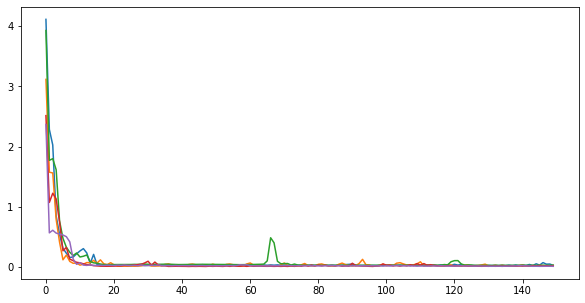

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(t1)
plt.plot(t2)
plt.plot(t3)
plt.plot(t4)
plt.plot(t5)

Model Inference (running on test data)

In [29]:
# Inference

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

test_loss = [[], [], [], [], [], [], []]
test_outs = [[], [], [], [], [], []]
for i, data in enumerate(test_loader):
  X, y = data
  with torch.no_grad():
    out = pred_model(X)
    for j, pred in enumerate(out):
      pred = torch.unsqueeze(torch.squeeze(pred, dim=0), dim=2)
      l = losses_fn[j](pred, y[j].float())
      test_loss[j].append(l)
      test_outs[j].append(pred)
    att_out = attention1([X, out])    
    att_l = att_loss_fn(torch.squeeze(att_out, dim=0), torch.squeeze(y[0], dim=2))
    test_loss[-1].append(att_l)
    print('%d \tl1: %.3f \tl2: %.3f \tl3: %.3f \t14: %.3f \tl5: %.3f \tl6: %.3f \tatt_l: %.3f'%(i, \
                  test_loss[0][i], test_loss[1][i], test_loss[2][i], test_loss[3][i], \
                  test_loss[4][i], test_loss[5][i], test_loss[6][i]))

0 	l1: 0.010 	l2: 0.001 	l3: 0.011 	14: 0.002 	l5: 0.002 	l6: 0.022 	att_l: 0.018
1 	l1: 0.010 	l2: 0.002 	l3: 0.011 	14: 0.002 	l5: 0.002 	l6: 0.023 	att_l: 0.019
2 	l1: 0.011 	l2: 0.002 	l3: 0.011 	14: 0.003 	l5: 0.002 	l6: 0.023 	att_l: 0.020
3 	l1: 0.013 	l2: 0.002 	l3: 0.011 	14: 0.003 	l5: 0.002 	l6: 0.023 	att_l: 0.022
4 	l1: 0.014 	l2: 0.002 	l3: 0.010 	14: 0.003 	l5: 0.002 	l6: 0.024 	att_l: 0.023
5 	l1: 0.015 	l2: 0.002 	l3: 0.010 	14: 0.004 	l5: 0.002 	l6: 0.025 	att_l: 0.025
6 	l1: 0.016 	l2: 0.002 	l3: 0.009 	14: 0.004 	l5: 0.002 	l6: 0.026 	att_l: 0.026
7 	l1: 0.017 	l2: 0.002 	l3: 0.009 	14: 0.005 	l5: 0.002 	l6: 0.028 	att_l: 0.027
8 	l1: 0.017 	l2: 0.002 	l3: 0.008 	14: 0.005 	l5: 0.002 	l6: 0.029 	att_l: 0.028
9 	l1: 0.017 	l2: 0.002 	l3: 0.007 	14: 0.005 	l5: 0.002 	l6: 0.030 	att_l: 0.028
10 	l1: 0.017 	l2: 0.002 	l3: 0.007 	14: 0.005 	l5: 0.002 	l6: 0.031 	att_l: 0.029
11 	l1: 0.017 	l2: 0.002 	l3: 0.006 	14: 0.006 	l5: 0.002 	l6: 0.032 	att_l: 0.028
12 	l1: 0.017 

In [32]:
print("Testing Error")
print(torch.mean(torch.Tensor(test_loss[0])))
print(torch.mean(torch.Tensor(test_loss[1])))
print(torch.mean(torch.Tensor(test_loss[2])))
print(torch.mean(torch.Tensor(test_loss[3])))
print(torch.mean(torch.Tensor(test_loss[4])))
print(torch.mean(torch.Tensor(test_loss[5])))

Testing Error
tensor(0.0383)
tensor(0.2174)
tensor(0.0434)
tensor(0.5084)
tensor(0.0022)
tensor(0.3999)


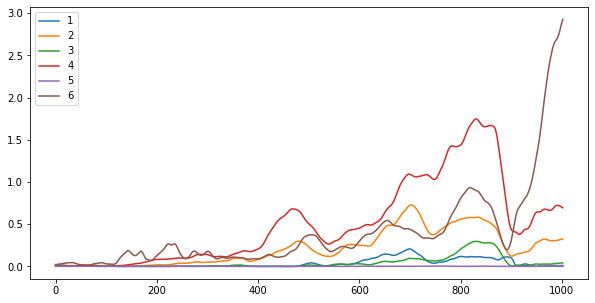

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(test_loss[0], label='1')
plt.plot(test_loss[1], label='2')
plt.plot(test_loss[2], label='3')
plt.plot(test_loss[3], label='4')
plt.plot(test_loss[4], label='5')
plt.plot(test_loss[5], label='6')
plt.legend(loc='upper left')

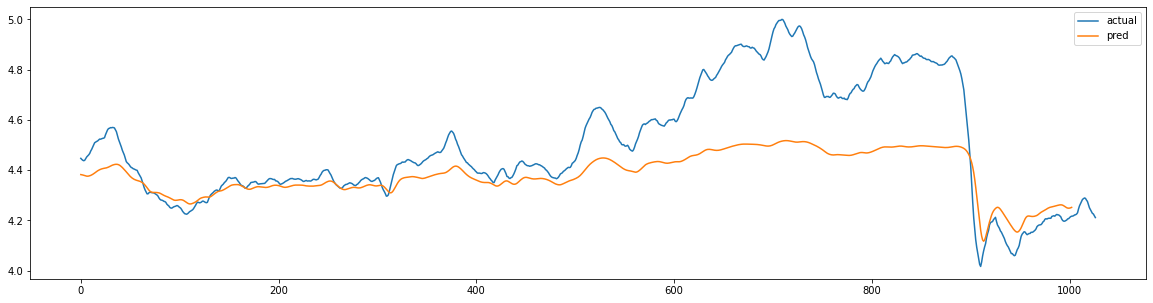

In [40]:
# View prediction and actual test series for AXIS Bank (our primary input)

p = 0
X_train = scaled_X[p][:n_train]
y_actual = scaled_X[p][n_train:len(scaled_X[p])-n_companies]
y_pred = []
for o in test_outs[p]:
  y_pred.append(o[0][0])
plt.figure(figsize=(20, 5))
#plt.plot(y_actual[:oup_len*3], label='actual')
#plt.plot(torch.squeeze(test_outs[p][0]).cpu(), label='pred')

plt.plot(y_actual, label='actual')
plt.plot(y_pred, label='pred')
plt.legend(loc='upper right')

In [41]:
#Save Loss lists

import pickle as pkl

with open('FNN_1Att_v2.pkl', 'wb') as f:
  obj = (lstm_loss2, att_loss2, test_loss, test_outs)
  pkl.dump(obj, f, pkl.HIGHEST_PROTOCOL)


In [10]:
import pickle as pkl
with open('FNN_1Att_v2.pkl', 'rb') as f:
  obj = pkl.load(f)
(lstm_loss2, att_loss2, test_loss, test_outs) = obj

with open('LSTM_1Att_v3.pkl', 'rb') as f:
  obj = pkl.load(f)
(lstm_loss2_, att_loss2_, test_loss_, test_outs_) = obj


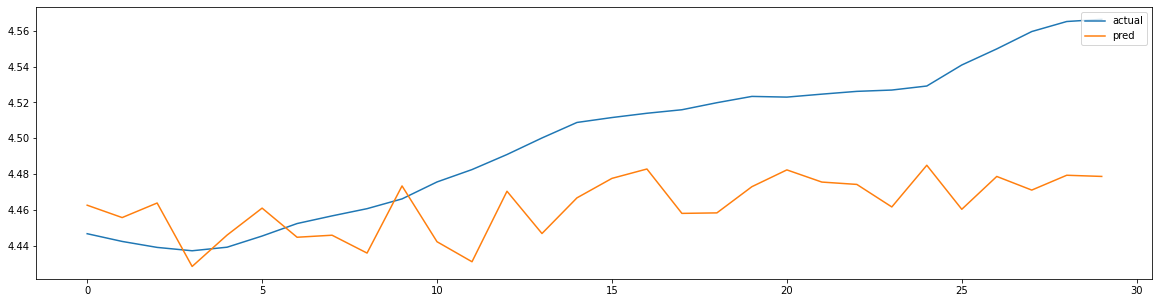

In [16]:
# View prediction and actual test series for AXIS Bank (our primary input)
n_train = int(len(scaled_X[0])*0.8)
n_companies = 6
oup_len = 30
p = 0
y_actual = scaled_X[p][n_train:len(scaled_X[p])-n_companies]
y_pred = []
for o in test_outs_[p]:
  y_pred.append(o[0][0])
plt.figure(figsize=(20, 5))
plt.plot(y_actual[:oup_len], label='actual')
plt.plot(torch.squeeze(test_outs_[p][0]).cpu(), label='pred')

#plt.plot(y_actual, label='actual')
#plt.plot(y_pred, label='pred')
plt.legend(loc='upper right')